# Deep Learning - Play Recognition

Going to be experimenting with a few image recognition models in this book.

## Conveniences

First, we change directories to the root of the project, so that we can import the `nfldata` module.

In [2]:
%cd ..
import fastbook
fastbook.setup_book()

/home/pradyothkukkapalli/Projects/nfldata


## Data

First we will download NFL highlights videos from YouTube using [`youtube-dl`](https://youtube-dl.org/).

In [2]:
from nfldata.learning.download import download_playlist

download_playlist(
    playlist_url='https://www.youtube.com/playlist?list=PLRdw3IjKY2gmSwNGqBUhDPxj4ib_7rNcs',
    output_directory='data/videos')

Next, we extract frames from the videos, each spaced out by one second.

In [3]:
from nfldata.learning.split import split_videos

split_videos(
    video_directory='data/videos',
    output_directory='data/frames')

Splitting data/videos/Buccaneers vs. Panthers Week 10 Highlights _ NFL 2020.mp4
Splitting data/videos/Ravens vs. Patriots Week 10 Highlights _ NFL 2020.mp4
Splitting data/videos/Seahawks vs. Rams Week 10 Highlights _ NFL 2020.mp4
Splitting data/videos/Washington Football Team vs. Lions Week 10 Highlights _ NFL 2020.mp4
Splitting data/videos/Jaguars vs. Packers Week 10 Highlights _ NFL 2020.mp4
Splitting data/videos/Bengals vs. Steelers Week 10 Highlights _ NFL 2020.mp4
Splitting data/videos/Colts vs. Titans Week 10 Highlights _ NFL 2020.mp4
Splitting data/videos/49ers vs. Saints Week 10 Highlights _ NFL 2020.mp4
Splitting data/videos/Vikings vs. Bears Week 10 Highlights _ NFL 2020.mp4
Splitting data/videos/Broncos vs. Raiders Week 10 Highlights _ NFL 2020.mp4
Splitting data/videos/Chargers vs. Dolphins Week 10 Highlights _ NFL 2020.mp4
Splitting data/videos/Eagles vs. Giants Week 10 Highlights _ NFL 2020.mp4
Splitting data/videos/Texans vs. Browns Week 10 Highlights _ NFL 2020.mp4
Spli

Now that we have our data, we need to label it, so that we can train some image recognition algorithms on them. This will label frames from NFL highlight videos. Pre-snap frames will be labeled as run/pass/st (special teams). All other frames will be labeled as junk.

In [2]:
from nfldata.learning.label import LabelingGui

gui = LabelingGui(
    directory_to_label='data/frames',
    labels=['run', 'pass', 'st', 'junk'],
    output_labels_file='data/run-pass-st.db')
gui.display()

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x80\x00\x00\x01h\x08\x02\x00\x00\x00HP\xdd\x06\x…

# Learning

Now that we have labeled data, let's try running a basic resnet18 learner.

In [2]:
from nfldata.learning.play_type import learn_play_type

learn = learn_play_type(
    labels_file='data/run-pass-st.db',
    epochs=10)

epoch,train_loss,valid_loss,error_rate,time
0,1.930927,1.692277,0.526391,00:03
1,1.613971,1.134833,0.388017,00:03
2,1.319806,1.040600,0.310984,00:03
3,1.064524,0.748433,0.229672,00:03
4,0.875328,0.548405,0.154066,00:03
5,0.742835,0.516682,0.156919,00:03
6,0.633052,0.443462,0.142653,00:03
7,0.541250,0.414356,0.142653,00:03
8,0.468416,0.441517,0.139800,00:03
9,0.403464,0.433430,0.145506,00:03


Looks like we're getting a ~16% error rate. Let's try applying some common image augmentations.

In [5]:
from nfldata.learning.play_type import learn_play_type

learn = learn_play_type(
    labels_file='data/run-pass-st.db',
    epochs=20,
    augment=True)

epoch,train_loss,valid_loss,error_rate,time
0,1.981491,1.286564,0.443760,00:03
1,1.664077,0.853227,0.323575,00:03
2,1.396241,0.772930,0.283513,00:03
3,1.176964,0.634648,0.212635,00:03
4,1.001495,0.557366,0.183359,00:04
5,0.843926,0.483342,0.171032,00:03
6,0.716923,0.471170,0.163328,00:04
7,0.613858,0.479688,0.171032,00:04
8,0.554160,0.428373,0.144838,00:04
9,0.487757,0.420008,0.147920,00:03


We got a moderate improvement, as the model seems to converge at ~13%. But it took more than 10 epochs to get there. Let's instead try a different architecture. The default is resnet18. Let's go deeper.

In [6]:
from fastai.vision.models import resnet50
from nfldata.learning.play_type import learn_play_type

learn = learn_play_type(
    labels_file='data/run-pass-st.db',
    epochs=20,
    augment=True,
    model=resnet50)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/pradyothkukkapalli/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,2.131958,1.281225,0.419106,00:07
1,1.656484,1.002581,0.325116,00:07
2,1.336957,0.723339,0.192604,00:07
3,1.089649,0.611098,0.172573,00:07
4,0.890782,0.554746,0.140216,00:07
5,0.736998,0.647342,0.155624,00:07
6,0.621799,0.606057,0.147920,00:07
7,0.528314,0.557628,0.140216,00:07
8,0.440406,0.531183,0.129430,00:07
9,0.379445,0.525144,0.120185,00:07


Going 50 layers deep doesn't give us a huge improvement either. That got me to thinking. How good is my error rate if I just guess the junk label?

In [10]:
import sqlite3

db = sqlite3.connect('data/run-pass-st.db')
db.execute('''
    WITH total_labels(ct) AS (
        SELECT count(*) FROM labels
    )
    SELECT label, COUNT(*) * 1.0 / total_labels.ct 
    FROM labels, total_labels GROUP BY label
''').fetchall()

[('junk', 0.8072866730584851),
 ('pass', 0.12559923298178333),
 ('run', 0.048418024928092045),
 ('st', 0.018696069031639503)]

Just guessing junk luckily only leads to an ~81% success rate, so our model is learning something! Let's try excluding the junk frames though.

In [10]:
from fastai.vision.models.xresnet import xresnet18
from nfldata.learning.play_type import learn_play_type

learn = learn_play_type(
    labels_file='data/run-pass-st.db',
    epochs=10,
    augment=True,
    model=xresnet18,
    exclude_labels={'junk'})

epoch,train_loss,valid_loss,error_rate,time
0,1.640429,6.246979,0.911765,00:03
1,1.374375,2.797313,0.779412,00:03
2,1.254906,0.741737,0.338235,00:03
3,1.143787,1.021259,0.463235,00:03
4,1.134923,1.260156,0.573529,00:03
5,1.071400,0.805477,0.235294,00:03
6,1.011002,1.436745,0.220588,00:03
7,0.970449,1.010701,0.220588,00:03
8,0.911998,0.979560,0.264706,00:03
9,0.870106,1.023493,0.205882,00:03


We eventually converge to around 20%, but is the classification algorithm simply learning to guess pass every time?

In [4]:
import sqlite3

db = sqlite3.connect('data/run-pass-st.db')
db.execute('''
    WITH total_labels(ct) AS (
        SELECT count(*) FROM labels
        WHERE label != 'junk'
    )
    SELECT label, COUNT(*) * 1.0 / total_labels.ct 
    FROM labels, total_labels
    WHERE label != 'junk'
    GROUP BY label
''').fetchall()

[('pass', 0.6517412935323383),
 ('run', 0.2512437810945274),
 ('st', 0.09701492537313433)]

Ok, now let's see what the confusion matrix looks like. Unfortunately it doesn't look good. It does indeed look like we're guessing pass too often. That makes sense given that we probably have more passing plays than run plays overall in the data.

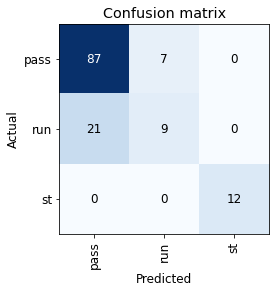

In [12]:
from fastai.interpret import ClassificationInterpretation

interpretation = ClassificationInterpretation.from_learner(learn)
interpretation.plot_confusion_matrix()

# Conclusion

The takeaway from this experiment is that deep learning probably cannot learn something which even humans are bad at predicting. We need something that humans are good at predicting just by looking at the picture.